In [1]:
import pathlib
from pathlib import Path
import os
import numpy as np
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following line uses the absolute path directory to read in where the training photos are saved, remember to put an 'r' in front for non-linux devices.

In [0]:
train = Path('/content/drive/My Drive/Colab Notebooks/binary_train')
test = Path('/content/drive/My Drive/Colab Notebooks/binary_test')

train_count = len(list(train.glob('*/*.jpg')))
test_count = len(list(test.glob('*/*.jpg')))

In [24]:
train_count
#test_count

418

In [25]:
CLASS_NAMES = np.array([item.name for item in train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['images', 'default'], dtype='<U7')

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 648
IMG_WIDTH = 864
INPUT_HEIGHT = 24
INPUT_WIDTH = 32

STEPS_PER_EPOCH = np.ceil(train_count/BATCH_SIZE)

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes = list(CLASS_NAMES))


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes = list(CLASS_NAMES))




Found 418 images belonging to 16 classes.
Found 59 images belonging to 16 classes.


In [26]:
A1 = Input(shape=(INPUT_HEIGHT,INPUT_WIDTH,3),name='A1')
A2 = Conv2D(32, (3, 4), 
                 activation='relu', 
                 padding='same', 
                 name='A2')
A3 = Conv2D(32, (3, 4), activation='relu', padding='same',name='A3')(A2)
A4 = MaxPooling2D(pool_size=(2, 2),name='A4')(A3)
A5 = Dropout(0.25,name='A5')(A4)
A6 = Flatten(name='A6')(A5)
A7 = Dense(512, activation='relu',name='A7')(A6)
A8 = Dropout(0.5,name='A8')(A7)
A9 = Dense(16, activation='tanh',name='A9')(A8)


B2 = Dense(40, activation='relu',name='B2')(A2)
B3 = Dense(30, activation='relu',name='B3')(B2)

model = Model(inputs=[A1],outputs=[A3,B3])
plot_model(model,show_shapes=True)

NameError: ignored

In [8]:
"""
model = Sequential()

model.add(Conv2D(32, (3, 4), 
                 activation='relu', 
                 padding='same', 
                 input_shape=(INPUT_HEIGHT,INPUT_WIDTH,3)))
model.add(Conv2D(32, (3, 4), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 4), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='softmax'))
"""






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 32, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 32, 32)        12320     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 16, 64)        24640     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 16, 64)        49216     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)         

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
14/14 [==============================] - 7s 517ms/step - loss: 2.7530 - acc: 0.1389 - val_loss: 2.7291 - val_acc: 0.2000
Epoch 2/50
14/14 [==============================] - 7s 488ms/step - loss: 2.7201 - acc: 0.1570 - val_loss: 2.4908 - val_acc: 0.2653
Epoch 3/50
14/14 [==============================] - 7s 472ms/step - loss: 2.5894 - acc: 0.1839 - val_loss: 1.8968 - val_acc: 0.5102
Epoch 4/50
14/14 [==============================] - 6s 462ms/step - loss: 2.1375 - acc: 0.3452 - val_loss: 1.1445 - val_acc: 0.7551
Epoch 5/50
14/14 [==============================] - 7s 488ms/step - loss: 1.8738 - acc: 0.3903 - val_loss: 0.7899 - val_acc: 0.8571
Epoch 6/50
14/14 [==============================] - 7s 473ms/step - loss: 1.4704 - acc: 0.5271 - val_loss: 0.8219 - val_acc: 0.8367
Epoch 7/50
14/14 [==============================] - 7s 468ms/step - loss: 1.2671 - acc: 0.5606 - val_loss: 0.3088 

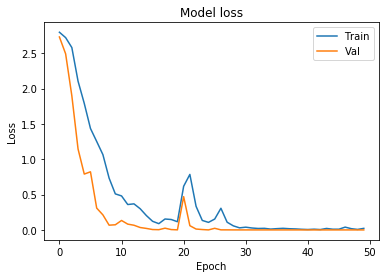

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [13]:
model.evaluate(x=validation_generator)[1]

6/6 [==============================] - 1s 122ms/step


1.0

In [0]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (24, 32, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/drive/My Drive/Colab Notebooks/binary_test/images/0_middle.jpg')
results = model.predict(image)

In [21]:
CLASS_NAMES[np.argmax(results)]



'2'

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/mymodel.h5')

From this point onwards, refer to https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata under "load using tf.data" to be able to load the dataset in keras. 